<h2 align='center'>Importing the Modules</h2>

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


<h2 align='center'>Creating the Dataset</h2>

In [3]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.long).to(device)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [4]:
data = pd.read_csv('text_image_embeddings.csv')
x_text = data['text_embedding'].str.split('\t', expand=True).astype(float).values
x_image = data['image_embedding'].str.split('\t', expand=True).astype(float).values
x = np.concatenate((x_text, x_image), axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['label'])

<h2 align='center'>Defining the Model</h2>

In [5]:
class CAML(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CAML, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_samples = 6
        self.epochs = 20
        self.alpha = 0.05  
        self.beta = 0.01  # meta learning rate
        self.theta = nn.Parameter(torch.randn(input_dim, output_dim).to(device))
        self.phi = nn.Parameter(torch.randn(input_dim, output_dim).to(device))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        a = torch.matmul(x, self.theta)
        return self.softmax(a)

    def sample_points(self, k, x, y):
        indices = np.random.choice(len(x), k)
        return x[indices], y[indices]

    def train(self, x_train, y_train, x_val, y_val):
        train_dataset = CustomDataset(x_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=self.num_samples, shuffle=True)

        optimizer = optim.Adam(self.parameters(), lr=self.alpha)

        for e in range(1, self.epochs + 1):
            self.theta_ = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_hat = self.forward(x_batch)
                y_batch_encoded = torch.eye(self.output_dim, device=device)[y_batch]
                loss = -torch.mean(y_batch_encoded * torch.log(y_hat + 1e-7))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                self.theta_.append(self.theta.detach().clone())

            meta_gradient = torch.zeros_like(self.theta, dtype=torch.float32).to(device)
            for i in range(self.num_samples):
                x_test, y_test = self.sample_points(10, x_train, y_train)
                x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
                y_pred = self.forward(x_test)
                y_test_encoded = torch.eye(self.output_dim)[y_test].to(device)
                meta_gradient += torch.matmul(x_test.T, (y_pred - y_test_encoded)) / self.num_samples

            self.theta.data -= self.beta * meta_gradient

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)
                x_val = torch.tensor(x_val, dtype=torch.float32).to(device).clone().detach().requires_grad_(True)
            y_val_pred = self.forward(x_val)
            val_loss = -torch.mean(torch.eye(self.output_dim, device=device)[y_val] * torch.log(y_val_pred + 1e-7))

            context_loss = torch.mean(torch.abs(self.theta - self.phi))
            kl_divergence = torch.mean(torch.abs(self.theta - self.phi) * torch.log(torch.abs(self.theta - self.phi) / (1e-7 + torch.abs(self.phi))))
            total_loss = val_loss + context_loss + kl_divergence

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

    def predict(self, x):
        with torch.no_grad():
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)
                x = torch.tensor(x, dtype=torch.float32).to(device)
            y_pred = self.forward(x)
            _, predictions = torch.max(y_pred, dim=1)
            return predictions.cpu().numpy()

In [6]:
num_labels = len(label_encoder.classes_)
print(num_labels)

6


<h2 align='center'>Training the Model</h2>

In [7]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.8,stratify=y, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,stratify=y_temp, random_state=42)

model = CAML(input_dim=x.shape[1], output_dim=num_labels).to(device)

model.train(x_train, y_train, x_val, y_val)

label_accuracy = {}
for label_idx, label in enumerate(label_encoder.classes_):
    label_indices = np.where(y_val == label_idx)[0]
    label_x_val = x_val[label_indices]
    label_y_val = y_val[label_indices]
    with torch.no_grad():
        label_x_val_tensor = torch.tensor(label_x_val, dtype=torch.float32).to(device)
        label_y_val_pred = model.predict(label_x_val_tensor)
        label_accuracy[label] = accuracy_score(label_y_val, label_y_val_pred)

In [8]:
for label, accuracy in label_accuracy.items():
    print(f"Label: {label}, Accuracy: {accuracy:.4f}")

Label: 0, Accuracy: 0.6239
Label: 1, Accuracy: 0.7462
Label: 2, Accuracy: 0.6963
Label: 3, Accuracy: 0.7126
Label: 4, Accuracy: 0.9443
Label: 5, Accuracy: 0.8731


In [9]:
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
    y_test_pred = model.predict(x_test_tensor)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Testing Accuracy: {test_accuracy:.4f}")

Testing Accuracy: 0.7647


<h2 align='center'>Making a Predictive System</h2>

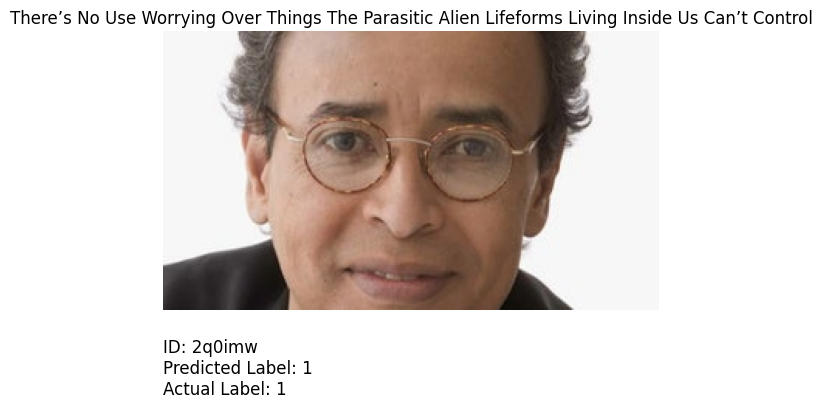

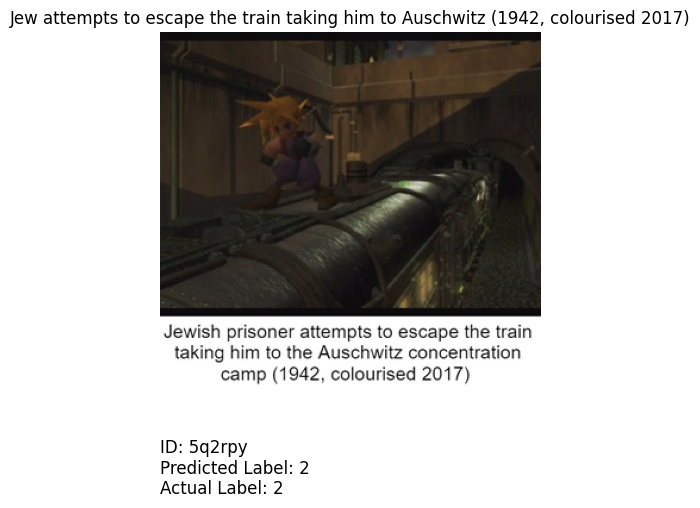

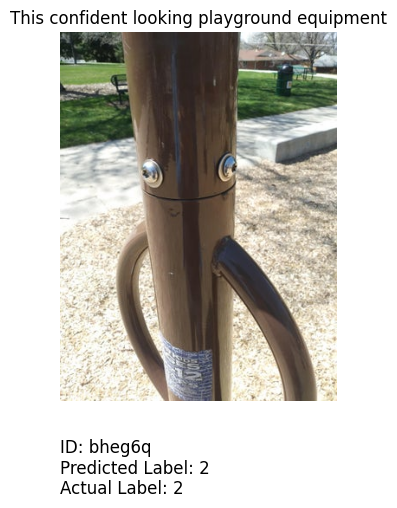

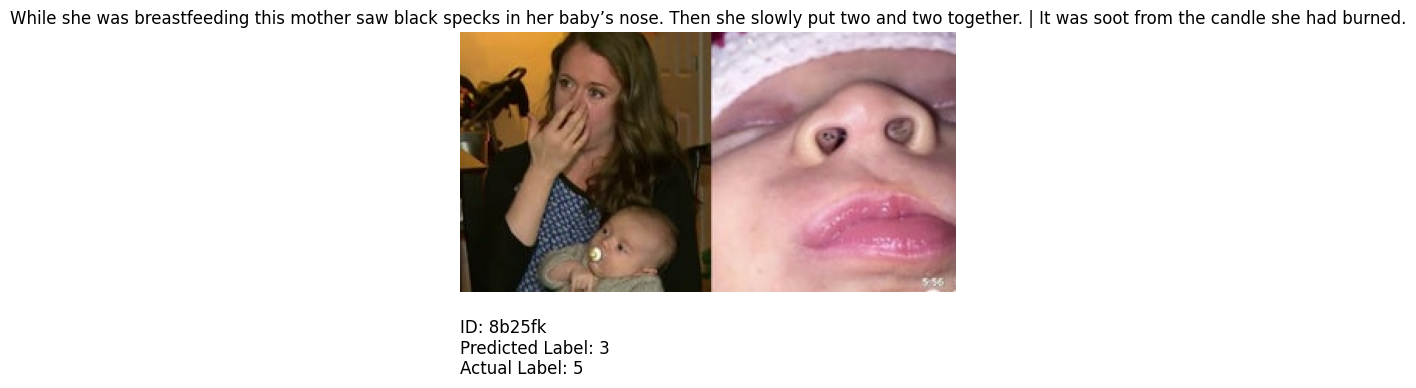

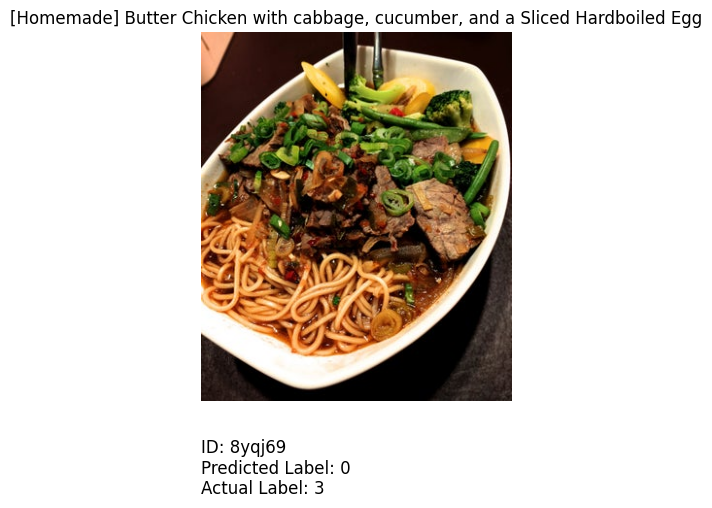

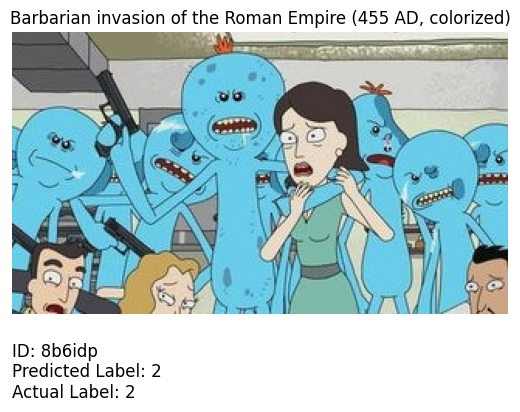

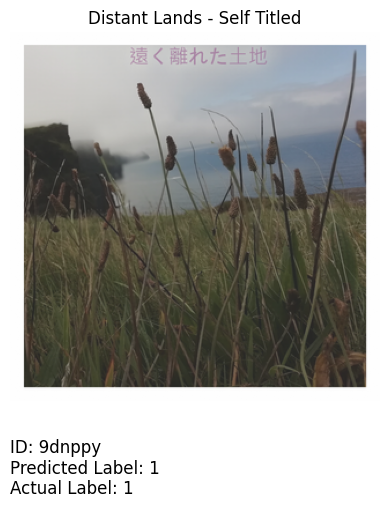

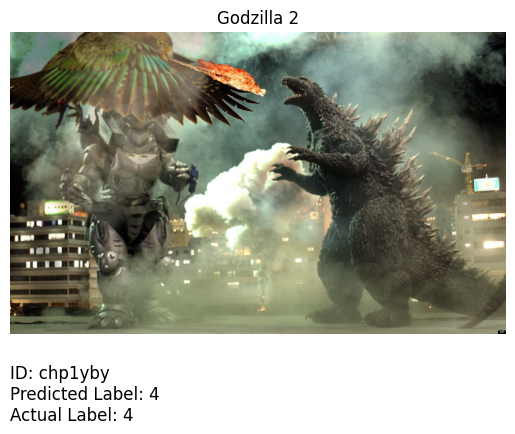

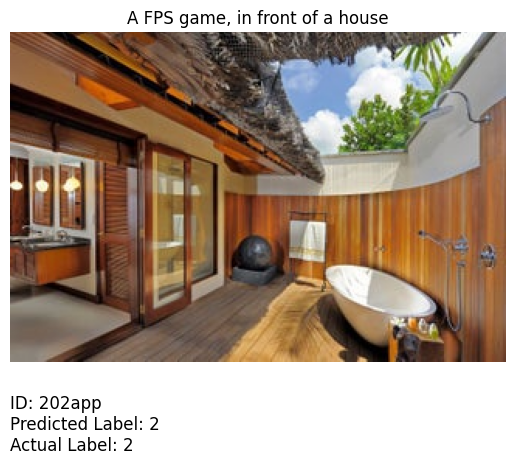

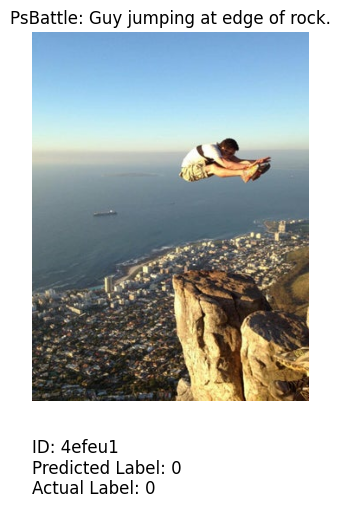

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

test_data = pd.read_csv('text_image_embeddings_test.csv')
text_data = pd.read_csv('text_dataset.tsv', sep='\t')

merged_data = pd.merge(test_data, text_data, on='id')

random_samples = merged_data.sample(n=10)

for index, row in random_samples.iterrows():
    print('\n')
    print('\n')
    x_text = np.array(row['text_embedding'].split('\t')).astype(float)
    x_image = np.array(row['image_embedding'].split('\t')).astype(float)
    x = np.concatenate((x_text, x_image))
    x = torch.tensor(x, dtype=torch.float32).to(device).unsqueeze(0)
    y_pred = model.predict(x)
    predicted_label = label_encoder.inverse_transform([y_pred])[0]
    actual_label = row['label']
    
    text = f"ID: {row['id']}\nPredicted Label: {predicted_label}\nActual Label: {actual_label}"
    plt.text(0, -0.1, text, fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)

    img = mpimg.imread(row['image_path'])
    imgplot = plt.imshow(img)
    plt.title(row['title'])
    plt.axis('off')
    plt.show()


<h2 align='center'>Analysing the Mispredictions</h2>

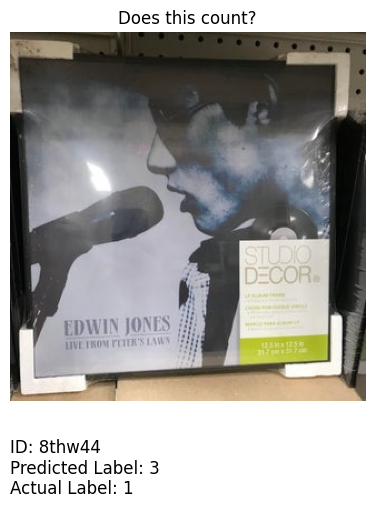

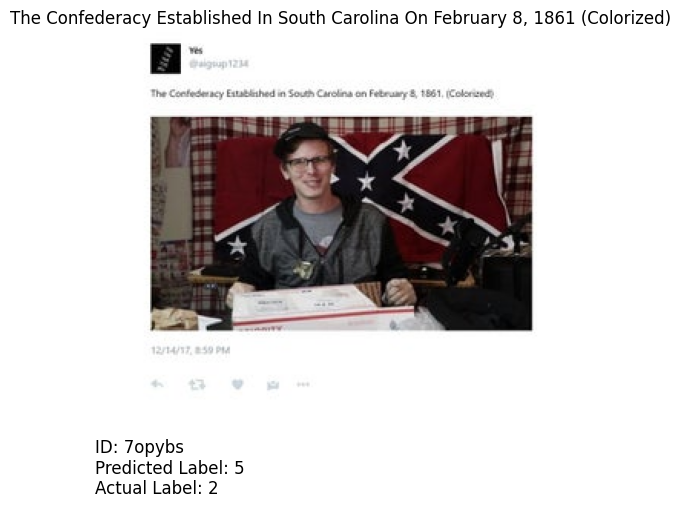

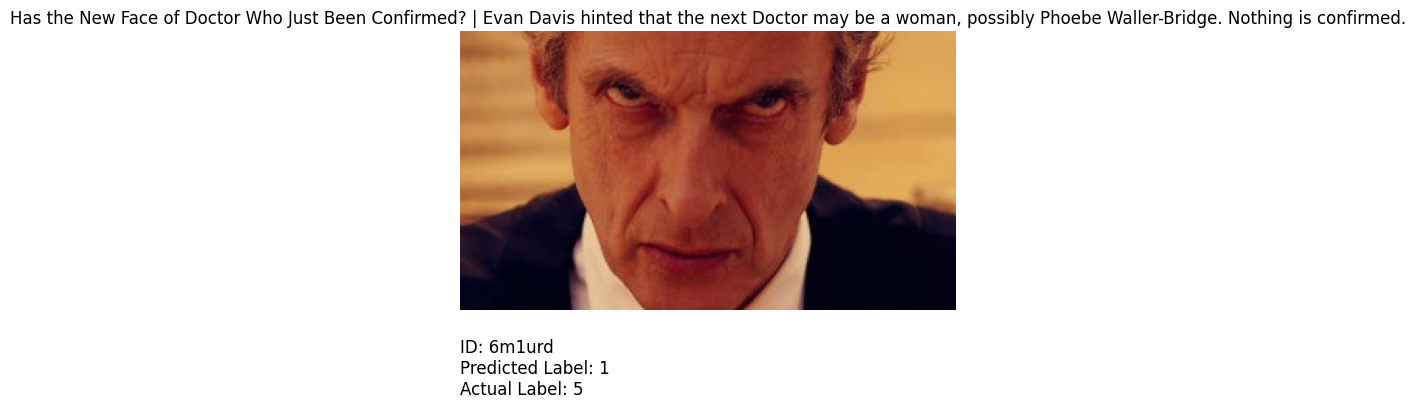

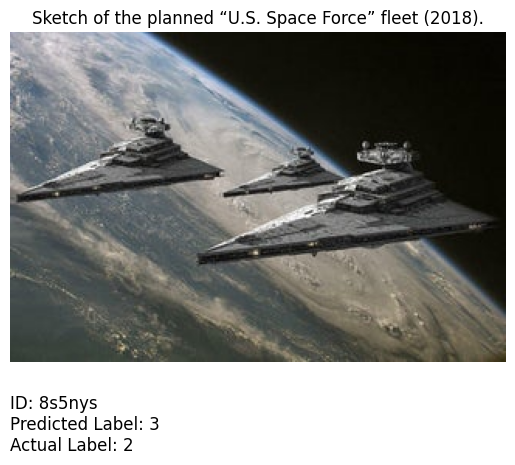

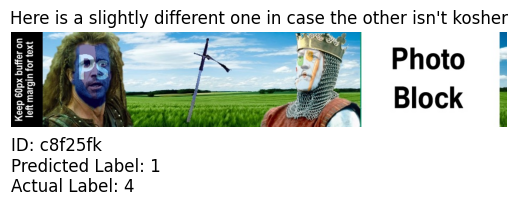

In [23]:
mispredicted_samples = 0
random_samples = merged_data.sample(n=1000)
for index, row in random_samples.iterrows():
    x_text = np.array(row['text_embedding'].split('\t')).astype(float)
    x_image = np.array(row['image_embedding'].split('\t')).astype(float)
    x = np.concatenate((x_text, x_image))
    x = torch.tensor(x, dtype=torch.float32).to(device).unsqueeze(0)
    y_pred = model.predict(x)
    predicted_label = label_encoder.inverse_transform([y_pred])[0]
    actual_label = row['label']
    
    if predicted_label != actual_label:
        mispredicted_samples += 1
        img = mpimg.imread(row['image_path'])
        imgplot = plt.imshow(img)
        text = f"ID: {row['id']}\nPredicted Label: {predicted_label}\nActual Label: {actual_label}"
        plt.text(0, -0.1, text, fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
        plt.title(row['title'])
        plt.axis('off')
        plt.show()
        
    if mispredicted_samples == 5:
        break
